# 1. IMPORT

In [1]:
#필요한 모듈을 import 합니다.
from numba import cuda

#이후 초기화 작업을 진행해줍니다.
device = cuda.get_current_device()
device.reset()

In [2]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
from pytorchtools import EarlyStopping

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim import AdamW

import matplotlib as mpl
import matplotlib.pyplot as plt

from transformers import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings(action='ignore')


/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
device = torch.device('cuda')if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [6]:
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


# 하이퍼파라미터 설정

In [7]:
class config():
    def __init__(self):
        
        self.source_len=128
        self.epochs = 10
        self.learning_rate=0.000003
        self.batch_size=16
        self.shuffle = True
        self.seed=800
        self.num_labels=10
        self.data_path= '/home/work/CL/dataset/healthcare/healthcare5000.pickle'
        self.model_path = 'klue/roberta-large'
        # self.modelsave_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
        # self.loss_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
cfg = config()

# 랜덤시드 고정

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.bachends.cudnn.bechmark = True
    
    seed_everything(cfg.seed) #seed 고정

# 데이터 로드

In [9]:
# trainset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_train.pickle')
# testset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_test.pickle')
# valset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_val.pickle')

trainset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_train.pickle')
testset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_test.pickle')
valset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_val.pickle')

In [10]:
for i in range(20):
    
    save_path = f"/home/work/CL/dataset/healthcare/16_asc{i+1}_combined.csv"
    globals()['trainset{}'.format(i+1)]= pd.read_csv(save_path)

In [11]:
trainset1

,clean_text,cos_dis,수도라벨
0,나병환자의 피부도말 검사의 염색법과 판독법에 대하여 고찰한다,0.292617,8
1,기존 유모차 또는 휠체어를 계단 에스컬레이터 및 경사로에서 안전하게 사용할 수 있도...,0.312076,5
2,전라남도 중고등학생들의 우울 정도와 자살에 대한 실태를 파악하고 어떠한 요소가 영향...,0.293319,8
3,및 유전자조작생쥐를 이용한 면역관용파괴 및 항암효과분석,0.307755,8
4,기존의 물리치료 장비는 냉각치료 기능이 없거나 별도의 냉각치료 장비를 구비하여 사용,0.316436,9
...,...,...,...
2939,주관기관 메디아나\n 개발\n 진단 기능의 측정 모듈 개발\n 실시간 진단 기능\n...,0.795272,9
2940,보급형 질량분석 진단기기 시제품 제작 기술 개발 \n 아래 사양을 만족하는 질량분석...,0.813591,9
2941,일회용 내시경 시스템 시제품 제작\n 및 채널을 구비한 벤딩 경비 내시경 시제품 제...,0.804985,9
2942,제품의 모듈화표준화를 통한 비용 절감과 사용자의 다양한 니즈를 충족시키고 사용자 중...,0.791470,5


In [12]:
trainset2

,clean_text,cos_dis,수도라벨
0,조직재생공학연구소는 중점연구소사업을통해손상된뼈치아신경이라는타겟조직을완벽히재생하기위한...,0.323545,7
1,조현병은 정신과 의사가 치료하는 질환 중에서 가장 이해하기 어려우면서도 비극적인 병...,0.317963,8
2,및 유전자조작생쥐를 이용한 면역관용파괴 및 항암효과분석,0.307755,8
3,이 신생혈관형성에 미치는 효과 및 관련 기전 규명,0.298206,6
4,기존 유모차 또는 휠체어를 계단 에스컬레이터 및 경사로에서 안전하게 사용할 수 있도...,0.312076,5
...,...,...,...
2939,현장진료를 위한 융합 지능형 휴대용 초음파 영상 시스템 요소 기술 개발\n 지능형 ...,0.794468,9
2940,피부충진 조성물인 조직수복용 재료의 연구개발을 통한 고부가가치화 실현 클린룸 시설과...,0.788493,5
2941,다양한 감염성 병원균의 신속 정확한 진단을 위한 프로브를 개발하고 이들을 이용한 통...,0.795100,6
2942,제품의 모듈화표준화를 통한 비용 절감과 사용자의 다양한 니즈를 충족시키고 사용자 중...,0.791470,5


# 토크나이저와 모델 정의

In [13]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed

model = AutoModelForSequenceClassification.from_pretrained(cfg.model_path, num_labels=cfg.num_labels, output_hidden_states=False).cuda()
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

model.resize_token_embeddings(len(tokenizer))
model

model_state_dict = torch.load("/home/work/CL/final_ictmodel/ict5epoch.pt", map_location=device)
model.load_state_dict(model_state_dict)
# model = torch.nn.DataParallel(model)
# model = get_peft_model(model, peft_config).to(device)

# model.print_trainable_parameters()
# model


<All keys matched successfully>

# 커스텀 데이터셋

In [14]:
class CustomDataset(Dataset):
    
    def __init__(self, data, labels, tokenizer, source_len) :
    # 내가 필요한 것들을 가져와서 선처리
        self.data = data.copy()
        self.labels = labels.copy()
        self.tokenizer = tokenizer
        self.source_len = source_len
    
    def __getitem__(self, index) :
    # 데이터 셋에서 한 개의 데이터를 가져오는 함수 정의
    
        text = self.data[index]
        inputs = self.tokenizer(text,max_length=self.source_len,padding='max_length',truncation=True, return_tensors='pt')
        # inputs = self.tokenizer.batch_encode_plus([text], max_length= self.source_len, truncation=True, padding='max_length',return_tensors='pt')
        label = self.labels[index]
        
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        token_type_ids = inputs['token_type_ids'].squeeze()
        
        
        
    
        # input_ids = inputs['input_ids'][0]
        # attention_mask = inputs['attention_mask'][0]
        # token_type_ids = inputs['token_type_ids'][0]
        
        # return input_ids, attention_mask, token_type_ids, label
        
        inputs_dict = {
            'input_ids' : input_ids.to(device, dtype = torch.long),
            'attention_mask' : attention_mask.to(device, dtype = torch.long),
            'token_type_ids': token_type_ids.to(device, dtype = torch.long),
        }
        label = torch.tensor(label).to(device, dtype = torch.long)
        
        
        return inputs_dict, label
    
    def __len__(self) :
    # 데이터 셋의 길이
        return len(self.data)    

In [15]:
import pandas as pd

dataframes = []  # 데이터프레임 리스트 초기화

for i in range(1, 21):
    trainset = globals()[f"trainset{i}"]  # 동적으로 변수명을 활용하여 데이터프레임 가져오기
    dataframes.append(trainset)  # 데이터프레임 리스트에 추가

In [16]:
# 데이터프레임을 데이터셋으로 변환
datasets = []
for trainset in dataframes:
    dataset = CustomDataset(data=list([str(i) for i in trainset['clean_text'].values.copy()].copy()),
                            labels=list(trainset['수도라벨'].copy()),
                            tokenizer=tokenizer,
                            source_len=cfg.source_len)
    datasets.append(dataset)

# 데이터로더 생성
batch_size = 16
data_loaders = []
for dataset in datasets:
    data_loader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
    data_loaders.append(data_loader)
len(data_loaders)
# # 데이터로더 사용 예시
# for data_loader in data_loaders:
#     for batch in data_loader:
#         inputs_dict, label = batch
#         print(inputs_dict)
#         print(label)

20

In [17]:
# train_data = CustomDataset(data=list([str(i) for i in trainset['clean_text'].values.copy()].copy()),
#                            labels= list(trainset['수도라벨'].copy()),
#                            tokenizer= tokenizer,
#                            source_len= cfg.source_len)

val_data = CustomDataset(data=list([str(i) for i in valset['clean_text'].values.copy()].copy()),
                           labels= list(valset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)


test_data = CustomDataset(data=list([str(i) for i in testset['clean_text'].values.copy()].copy()),
                           labels= list(testset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

# train_loader = DataLoader(train_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
val_loader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
test_loader = DataLoader(test_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)


# Train, val 정의

In [18]:
def train(epoch, model, optimizer, loader):
    
    model.train()
    total_loss, total_accuracy = 0,0
    nb_train_steps = 0
    for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
        outputs = model(**inputs, labels = labels)
        loss = outputs.loss
        

        pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
        true = [label for label in labels.cpu().numpy()]
        acc = accuracy_score(true,pred)
        

        if _%32 ==0 : #만약 인덱스가 10이 되면
            print(f'Epoch : {epoch+1}, train_{_}_step_loss : {loss.item()}')
            psuedo_pred = [logit.argmax().item() for logit in outputs.logits]
            psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(psuedo_pred))/len(labels)
            print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        total_accuracy += acc
        nb_train_steps += 1
    

    
    avg_loss = total_loss/len(loader)
    avg_acc = total_accuracy/nb_train_steps
    t_test_avg_acc = total_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, train_{_}_stepLoss:{avg_loss}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{avg_acc}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{t_test_avg_acc}')
    loss_dic['train_loss'].append(avg_loss)
    loss_dic['train_acc'].append(avg_acc)

In [19]:
def validate(epoch, model, loader):
   
    model.eval()
    eval_loss, eval_accuracy = 0,0
    nb_eval_steps = 0
    with torch.no_grad():
        for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            eval_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            acc = accuracy_score(true,pred)
            eval_accuracy += acc
            nb_eval_steps +=1
            if _%32 ==0 : #만약 인덱스가 10이 되면
                print(f'Epoch : {epoch+1}, val_{_}_step_loss : {loss.item()}')
                predicted_class_id = [logit.argmax().item() for logit in outputs.logits]
                psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(predicted_class_id))/len(labels)
                print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
                
                
    e_avg_loss = eval_loss/len(loader)
    e_avg_acc = eval_accuracy/nb_eval_steps
    e_test_avg_acc = eval_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, val_{_}_stepLoss:{e_avg_loss}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_avg_acc}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_test_avg_acc}')

    loss_dic['validation_loss'].append(e_avg_loss)
    loss_dic['val_acc'].append(e_avg_acc)                
    loss_dic['epoch'].append(epoch+1)

    early_stopping(e_avg_loss, model)
    return e_avg_loss, e_test_avg_acc
    




In [20]:

def infer(model, loader):
    
    model.eval()
    test_loss, test_accuracy = 0,0
    result_dic = {'prediction':[], 'label':[]}
    with torch.no_grad():
        for _,(inputs, labels) in tqdm(enumerate(loader, 0)): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            test_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            result_dic['prediction'].append(pred)
            result_dic['label'].append(true)                

            acc = accuracy_score(true,pred)
            test_accuracy += acc
        
            
                
    t_avg_loss = test_loss/len(loader)
    t_avg_acc = test_accuracy/len(loader)
    print(f'test_{_}_stepLoss:{t_avg_loss}')
    print(f'test_{_}_stepacc:{t_avg_acc}')

    
    return t_avg_loss, t_avg_acc
    
        

# RUN

In [21]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr=0.000003)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.* (len(data_loader) * cfg.epochs),
    num_training_steps=(len(data_loader) * cfg.epochs),
)

In [22]:
loss_dic = {'epoch':[],'train_loss':[], 'validation_loss':[],'train_acc':[],'val_acc':[]}
early_stopping = EarlyStopping(patience = 3, verbose = True)


for epoch in tqdm(range(0,cfg.epochs)):
    train(epoch, model, optimizer, data_loaders[epoch])
    lr_scheduler.step()

    validate(epoch, model, val_loader)
    
    # if early_stopping.early_stop:
    #     break
    torch.save(model, f'/home/work/CL/final_healthmodel/asc_{epoch+1}epoch.pt')

    
    

df1 = pd.DataFrame(loss_dic)
df1.to_excel(f'/home/work/CL/final_healthmodel/asc.xlsx', index=False)
    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1, train_0_step_loss : 5.556787014007568
1_0_step_정확도 :0.0
Epoch : 1, train_32_step_loss : 1.8583732843399048
1_32_step_정확도 :0.25
Epoch : 1, train_64_step_loss : 1.421168565750122
1_64_step_정확도 :0.5
Epoch : 1, train_96_step_loss : 1.3149707317352295
1_96_step_정확도 :0.4375
Epoch : 1, train_128_step_loss : 1.0559780597686768
1_128_step_정확도 :0.75
Epoch : 1, train_160_step_loss : 1.1158467531204224
1_160_step_정확도 :0.4375
Epoch:1, train_183_stepLoss:1.5322764546650907
Epoch:1, train_183_stepacc:0.45516304347826086
Epoch:1, train_183_stepacc:0.45516304347826086
Epoch : 1, val_0_step_loss : 0.7662799954414368
1_0_step_정확도 :0.6875
Epoch : 1, val_32_step_loss : 1.0272501707077026
1_32_step_정확도 :0.5625
Epoch:1, val_61_stepLoss:0.9655575848394825
Epoch:1, val_61_stepacc:0.6442972350230415
Epoch:1, val_61_stepacc:0.6442972350230415
Validation loss decreased (inf --> 0.965558).  Saving model ...


 10%|█         | 1/10 [01:28<13:19, 88.79s/it]

Epoch : 2, train_0_step_loss : 1.2596564292907715
2_0_step_정확도 :0.5
Epoch : 2, train_32_step_loss : 1.0363099575042725
2_32_step_정확도 :0.6875
Epoch : 2, train_64_step_loss : 0.673973560333252
2_64_step_정확도 :0.8125
Epoch : 2, train_96_step_loss : 0.9357357025146484
2_96_step_정확도 :0.6875
Epoch : 2, train_128_step_loss : 0.5326430201530457
2_128_step_정확도 :0.75
Epoch : 2, train_160_step_loss : 0.7863945960998535
2_160_step_정확도 :0.5625
Epoch:2, train_183_stepLoss:0.85845330560013
Epoch:2, train_183_stepacc:0.6881793478260869
Epoch:2, train_183_stepacc:0.6881793478260869
Epoch : 2, val_0_step_loss : 0.6156771183013916
2_0_step_정확도 :0.75
Epoch : 2, val_32_step_loss : 1.0487713813781738
2_32_step_정확도 :0.5
Epoch:2, val_61_stepLoss:0.8723156755009005
Epoch:2, val_61_stepacc:0.6826036866359446
Epoch:2, val_61_stepacc:0.6826036866359446
Validation loss decreased (0.965558 --> 0.872316).  Saving model ...


 20%|██        | 2/10 [02:59<11:57, 89.66s/it]

Epoch : 3, train_0_step_loss : 1.0668281316757202
3_0_step_정확도 :0.6875
Epoch : 3, train_32_step_loss : 0.9112239480018616
3_32_step_정확도 :0.75
Epoch : 3, train_64_step_loss : 0.4651327133178711
3_64_step_정확도 :0.9375
Epoch : 3, train_96_step_loss : 0.7756816744804382
3_96_step_정확도 :0.75
Epoch : 3, train_128_step_loss : 0.3241472840309143
3_128_step_정확도 :0.875
Epoch : 3, train_160_step_loss : 0.6564969420433044
3_160_step_정확도 :0.75
Epoch:3, train_183_stepLoss:0.6975592765957117
Epoch:3, train_183_stepacc:0.7588315217391305
Epoch:3, train_183_stepacc:0.7588315217391305
Epoch : 3, val_0_step_loss : 0.5162892937660217
3_0_step_정확도 :0.75
Epoch : 3, val_32_step_loss : 1.093903660774231
3_32_step_정확도 :0.625
Epoch:3, val_61_stepLoss:0.8640663972304713
Epoch:3, val_61_stepacc:0.6873559907834101
Epoch:3, val_61_stepacc:0.6873559907834101
Validation loss decreased (0.872316 --> 0.864066).  Saving model ...


 30%|███       | 3/10 [04:30<10:32, 90.41s/it]

Epoch : 4, train_0_step_loss : 0.6982241868972778
4_0_step_정확도 :0.6875
Epoch : 4, train_32_step_loss : 0.7206987142562866
4_32_step_정확도 :0.75
Epoch : 4, train_64_step_loss : 0.32015037536621094
4_64_step_정확도 :0.9375
Epoch : 4, train_96_step_loss : 0.6282162666320801
4_96_step_정확도 :0.8125
Epoch : 4, train_128_step_loss : 0.2930987775325775
4_128_step_정확도 :0.875
Epoch : 4, train_160_step_loss : 0.43658772110939026
4_160_step_정확도 :0.875
Epoch:4, train_183_stepLoss:0.5530849545384231
Epoch:4, train_183_stepacc:0.8199728260869565
Epoch:4, train_183_stepacc:0.8199728260869565
Epoch : 4, val_0_step_loss : 0.4849478006362915
4_0_step_정확도 :0.875
Epoch : 4, val_32_step_loss : 1.2371364831924438
4_32_step_정확도 :0.5625
Epoch:4, val_61_stepLoss:0.895191214257671
Epoch:4, val_61_stepacc:0.6923963133640554
Epoch:4, val_61_stepacc:0.6923963133640554
EarlyStopping counter: 1 out of 3


 40%|████      | 4/10 [05:57<08:54, 89.10s/it]

Epoch : 5, train_0_step_loss : 0.6985288858413696
5_0_step_정확도 :0.75
Epoch : 5, train_32_step_loss : 0.5705174803733826
5_32_step_정확도 :0.875
Epoch : 5, train_64_step_loss : 0.26113924384117126
5_64_step_정확도 :0.875
Epoch : 5, train_96_step_loss : 0.4208793342113495
5_96_step_정확도 :0.8125
Epoch : 5, train_128_step_loss : 0.21428567171096802
5_128_step_정확도 :0.9375
Epoch : 5, train_160_step_loss : 0.21454815566539764
5_160_step_정확도 :1.0
Epoch:5, train_183_stepLoss:0.4326630369760096
Epoch:5, train_183_stepacc:0.8678668478260869
Epoch:5, train_183_stepacc:0.8678668478260869
Epoch : 5, val_0_step_loss : 0.4740104675292969
5_0_step_정확도 :0.875
Epoch : 5, val_32_step_loss : 1.4739336967468262
5_32_step_정확도 :0.5625
Epoch:5, val_61_stepLoss:0.9393327849045876
Epoch:5, val_61_stepacc:0.7098214285714285
Epoch:5, val_61_stepacc:0.7098214285714285
EarlyStopping counter: 2 out of 3


 50%|█████     | 5/10 [07:24<07:22, 88.48s/it]

Epoch : 6, train_0_step_loss : 0.7126449346542358
6_0_step_정확도 :0.8125
Epoch : 6, train_32_step_loss : 0.4979018568992615
6_32_step_정확도 :0.9375
Epoch : 6, train_64_step_loss : 0.28507715463638306
6_64_step_정확도 :0.875
Epoch : 6, train_96_step_loss : 0.48347312211990356
6_96_step_정확도 :0.8125
Epoch : 6, train_128_step_loss : 0.08903095871210098
6_128_step_정확도 :1.0
Epoch : 6, train_160_step_loss : 0.08617179840803146
6_160_step_정확도 :1.0
Epoch:6, train_183_stepLoss:0.3427009209180656
Epoch:6, train_183_stepacc:0.9001358695652174
Epoch:6, train_183_stepacc:0.9001358695652174
Epoch : 6, val_0_step_loss : 0.5820875763893127
6_0_step_정확도 :0.875
Epoch : 6, val_32_step_loss : 1.5033987760543823
6_32_step_정확도 :0.5
Epoch:6, val_61_stepLoss:1.0175544006689903
Epoch:6, val_61_stepacc:0.7014688940092166
Epoch:6, val_61_stepacc:0.7014688940092166
EarlyStopping counter: 3 out of 3


 60%|██████    | 6/10 [08:51<05:51, 87.91s/it]

Epoch : 7, train_0_step_loss : 0.4049069285392761
7_0_step_정확도 :0.8125
Epoch : 7, train_32_step_loss : 0.45284998416900635
7_32_step_정확도 :0.9375
Epoch : 7, train_64_step_loss : 0.26050329208374023
7_64_step_정확도 :0.9375
Epoch : 7, train_96_step_loss : 0.3357933759689331
7_96_step_정확도 :0.9375
Epoch : 7, train_128_step_loss : 0.06442555040121078
7_128_step_정확도 :1.0
Epoch : 7, train_160_step_loss : 0.21870560944080353
7_160_step_정확도 :0.875
Epoch:7, train_183_stepLoss:0.2676951103216118
Epoch:7, train_183_stepacc:0.9249320652173914
Epoch:7, train_183_stepacc:0.9249320652173914
Epoch : 7, val_0_step_loss : 0.6701026558876038
7_0_step_정확도 :0.8125
Epoch : 7, val_32_step_loss : 1.4431874752044678
7_32_step_정확도 :0.5625
Epoch:7, val_61_stepLoss:1.0391775561917214
Epoch:7, val_61_stepacc:0.723934331797235
Epoch:7, val_61_stepacc:0.723934331797235
EarlyStopping counter: 4 out of 3


 70%|███████   | 7/10 [10:18<04:23, 87.69s/it]

Epoch : 8, train_0_step_loss : 0.23114661872386932
8_0_step_정확도 :0.875
Epoch : 8, train_32_step_loss : 0.3098161816596985
8_32_step_정확도 :0.9375
Epoch : 8, train_64_step_loss : 0.11178678274154663
8_64_step_정확도 :1.0
Epoch : 8, train_96_step_loss : 0.41201886534690857
8_96_step_정확도 :0.875
Epoch : 8, train_128_step_loss : 0.05184207484126091
8_128_step_정확도 :1.0
Epoch : 8, train_160_step_loss : 0.0900537297129631
8_160_step_정확도 :1.0
Epoch:8, train_183_stepLoss:0.21584208049487486
Epoch:8, train_183_stepacc:0.9436141304347826
Epoch:8, train_183_stepacc:0.9436141304347826
Epoch : 8, val_0_step_loss : 0.8522267937660217
8_0_step_정확도 :0.8125
Epoch : 8, val_32_step_loss : 1.5938746929168701
8_32_step_정확도 :0.5
Epoch:8, val_61_stepLoss:1.093092015794208
Epoch:8, val_61_stepacc:0.7078052995391705
Epoch:8, val_61_stepacc:0.7078052995391705
EarlyStopping counter: 5 out of 3


 80%|████████  | 8/10 [11:46<02:55, 87.63s/it]

Epoch : 9, train_0_step_loss : 0.4510708749294281
9_0_step_정확도 :0.875
Epoch : 9, train_32_step_loss : 0.09065167605876923
9_32_step_정확도 :1.0
Epoch : 9, train_64_step_loss : 0.1721208691596985
9_64_step_정확도 :0.875
Epoch : 9, train_96_step_loss : 0.4251973032951355
9_96_step_정확도 :0.8125
Epoch : 9, train_128_step_loss : 0.04004860669374466
9_128_step_정확도 :1.0
Epoch : 9, train_160_step_loss : 0.04038216173648834
9_160_step_정확도 :1.0
Epoch:9, train_183_stepLoss:0.16040533260219608
Epoch:9, train_183_stepacc:0.9592391304347826
Epoch:9, train_183_stepacc:0.9592391304347826
Epoch : 9, val_0_step_loss : 0.7022708654403687
9_0_step_정확도 :0.875
Epoch : 9, val_32_step_loss : 1.720293402671814
9_32_step_정확도 :0.625
Epoch:9, val_61_stepLoss:1.1191486865282059
Epoch:9, val_61_stepacc:0.7186059907834101
Epoch:9, val_61_stepacc:0.7186059907834101
EarlyStopping counter: 6 out of 3


 90%|█████████ | 9/10 [13:13<01:27, 87.49s/it]

Epoch : 10, train_0_step_loss : 0.10674793273210526
10_0_step_정확도 :1.0
Epoch : 10, train_32_step_loss : 0.08598123490810394
10_32_step_정확도 :1.0
Epoch : 10, train_64_step_loss : 0.03538649529218674
10_64_step_정확도 :1.0
Epoch : 10, train_96_step_loss : 0.2312118262052536
10_96_step_정확도 :0.9375
Epoch : 10, train_128_step_loss : 0.051749370992183685
10_128_step_정확도 :1.0
Epoch : 10, train_160_step_loss : 0.057033341377973557
10_160_step_정확도 :1.0
Epoch:10, train_183_stepLoss:0.1394462426415766
Epoch:10, train_183_stepacc:0.9619565217391305
Epoch:10, train_183_stepacc:0.9619565217391305
Epoch : 10, val_0_step_loss : 0.6960678696632385
10_0_step_정확도 :0.875
Epoch : 10, val_32_step_loss : 1.6472867727279663
10_32_step_정확도 :0.5625
Epoch:10, val_61_stepLoss:1.1205257052375424
Epoch:10, val_61_stepacc:0.7377592165898618
Epoch:10, val_61_stepacc:0.7377592165898618
EarlyStopping counter: 7 out of 3


100%|██████████| 10/10 [14:40<00:00, 88.05s/it]


In [23]:
df1

,epoch,train_loss,validation_loss,train_acc,val_acc
0,1,1.532276,0.965558,0.455163,0.644297
1,2,0.858453,0.872316,0.688179,0.682604
2,3,0.697559,0.864066,0.758832,0.687356
3,4,0.553085,0.895191,0.819973,0.692396
4,5,0.432663,0.939333,0.867867,0.709821
5,6,0.342701,1.017554,0.900136,0.701469
6,7,0.267695,1.039178,0.924932,0.723934
7,8,0.215842,1.093092,0.943614,0.707805
8,9,0.160405,1.119149,0.959239,0.718606
9,10,0.139446,1.120526,0.961957,0.737759


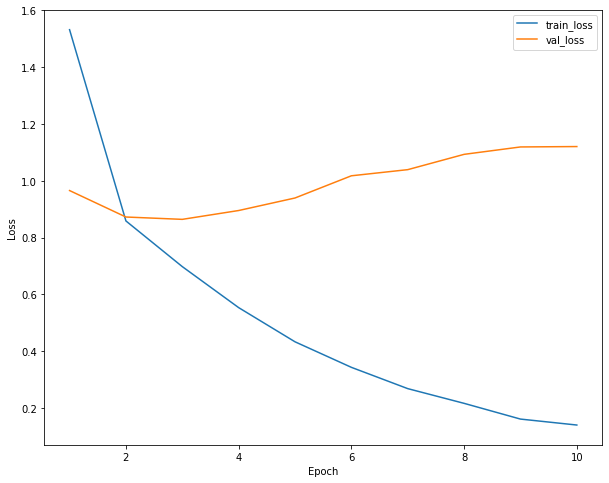

In [24]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(df1['epoch'],df1['train_loss'],label='train_loss')
plt.plot(df1['epoch'],df1['validation_loss'],label='val_loss')
# plt.plot(loss_dic['epoch'],nolora_df['train_loss'],label='no_lora_trainloss')
# plt.plot(loss_dic['epoch'],nolora_df['validation_loss'],label='no_lora_valloss')

plt.legend()
plt.show()

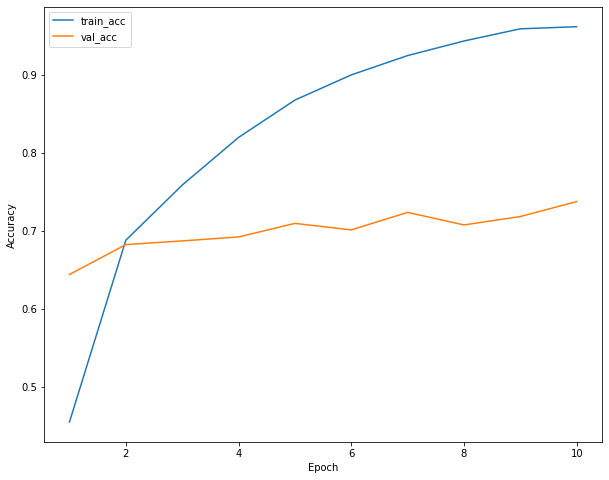

In [25]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(df1['epoch'],df1['train_acc'],label='train_acc')
plt.plot(df1['epoch'],df1['val_acc'],label='val_acc')
# plt.plot(loss_dic['epoch'],nolora_df['train_acc'],label='no_lora_train_acc')
# plt.plot(loss_dic['epoch'],nolora_df['val_acc'],label='no_lora_acc')
plt.legend()
plt.show()

## 오름차순의 추론


In [26]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

for i in range(20) :
    save_path = f"/home/work/CL/final_healthmodel/asc_{i+1}epoch.pt"
    model = torch.load(save_path)

    print(i+1,infer(model=model,loader=test_loader))



62it [00:07,  7.83it/s]


test_61_stepLoss:0.9115182882355105
test_61_stepacc:0.6733870967741935
1 (0.9115182882355105, 0.6733870967741935)


62it [00:07,  7.84it/s]


test_61_stepLoss:0.8047334419623497
test_61_stepacc:0.7016129032258065
2 (0.8047334419623497, 0.7016129032258065)


62it [00:07,  7.79it/s]


test_61_stepLoss:0.7934702132498065
test_61_stepacc:0.7127016129032258
3 (0.7934702132498065, 0.7127016129032258)


62it [00:07,  7.86it/s]


test_61_stepLoss:0.826463503462653
test_61_stepacc:0.7157258064516129
4 (0.826463503462653, 0.7157258064516129)


62it [00:07,  7.83it/s]


test_61_stepLoss:0.8692453638199837
test_61_stepacc:0.717741935483871
5 (0.8692453638199837, 0.717741935483871)


62it [00:07,  7.84it/s]


test_61_stepLoss:0.9609736963625877
test_61_stepacc:0.7247983870967742
6 (0.9609736963625877, 0.7247983870967742)


62it [00:07,  7.83it/s]


test_61_stepLoss:1.0000694598401747
test_61_stepacc:0.7237903225806451
7 (1.0000694598401747, 0.7237903225806451)


62it [00:07,  7.86it/s]


test_61_stepLoss:1.0734494016055138
test_61_stepacc:0.7217741935483871
8 (1.0734494016055138, 0.7217741935483871)


62it [00:07,  7.80it/s]


test_61_stepLoss:1.1496918295179643
test_61_stepacc:0.719758064516129
9 (1.1496918295179643, 0.719758064516129)


62it [00:07,  7.84it/s]


test_61_stepLoss:1.1162035781289301
test_61_stepacc:0.7459677419354839
10 (1.1162035781289301, 0.7459677419354839)


FileNotFoundError: [Errno 2] No such file or directory: '/home/work/CL/final_healthmodel/asc_11epoch.pt'